# Removing Motion Blur from Corrupt CIFAR-10 images


In [ ]:
# Import libraries
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
import time

### Load data


In [2]:
(x_train, _), (x_test, _) = tf.keras.datasets.cifar10.load_data()

### Create motion blur images


In [3]:
# Motion blur angle (do not change)
min_angle = 0
max_angle = 180

In [4]:
# Motion blur generation routines
def create_motion_blur_kernel(size, angle):
    kernel = np.zeros((size, size), dtype=np.float32)
    center = (size - 1) / 2.0

    radian_angle = np.deg2rad(angle)
    dx = np.cos(radian_angle)
    dy = np.sin(radian_angle)
    x1 = int(round(center - dx * center))
    y1 = int(round(center - dy * center))
    x2 = int(round(center + dx * center))
    y2 = int(round(center + dy * center))

    cv2.line(kernel, (x1, y1), (x2, y2), 1.0, thickness=1)

    kernel[kernel < 0] = 0
    kernel_sum = kernel.sum()
    if kernel_sum == 0:
        kernel[int(center), int(center)] = 1.0
    else:
        kernel /= kernel_sum

    return kernel


def add_motion_blur(images, ksize, min_angle, max_angle, seed=123):

    blurred_images = np.zeros_like(images, dtype=np.float32)
    rng = np.random.RandomState(seed)

    for i in range(len(images)):

        image = images[i]

        # Parameters of motion blur kernel
        if ksize % 2 == 0:
            ksize += 1
        angle = rng.uniform(min_angle, max_angle)

        # Create motion blur kernel
        kernel = create_motion_blur_kernel(ksize, angle)

        # Apply kernel
        blurred_img = cv2.filter2D(image, -1, kernel)

        # 5. Clip and store
        blurred_images[i] = np.clip(blurred_img, 0.0, 255.0)

    return blurred_images.astype(np.int16)

In [5]:
# Blur kernel size (change this here)
kernel_size = 7  # default for now

## Motion blurred image generation


In [6]:
x_train_blurred_mild = add_motion_blur(x_train, min_angle=0, max_angle=180, ksize=3)
x_test_blurred_mild = add_motion_blur(x_test, min_angle=0, max_angle=180, ksize=3)

x_train_blurred_medium = add_motion_blur(x_train, min_angle=0, max_angle=180, ksize=7)
x_test_blurred_medium = add_motion_blur(x_test, min_angle=0, max_angle=180, ksize=7)

x_train_blurred_strong = add_motion_blur(x_train, min_angle=0, max_angle=180, ksize=11)
x_test_blurred_strong = add_motion_blur(x_test, min_angle=0, max_angle=180, ksize=11)

In [ ]:
# Normalize images
normalize_img = lambda image: image / 255.0

# original images
x_train = normalize_img(x_train)
x_test = normalize_img(x_test)

# mild blur
x_train_blurred_mild = normalize_img(x_train_blurred_mild)
x_test_blurred_mild = normalize_img(x_test_blurred_mild)

# medium blur
x_train_blurred_medium = normalize_img(x_train_blurred_medium)
x_test_blurred_medium = normalize_img(x_test_blurred_medium)

# strong blur
x_train_blurred_strong = normalize_img(x_train_blurred_strong)
x_test_blurred_strong = normalize_img(x_test_blurred_strong)

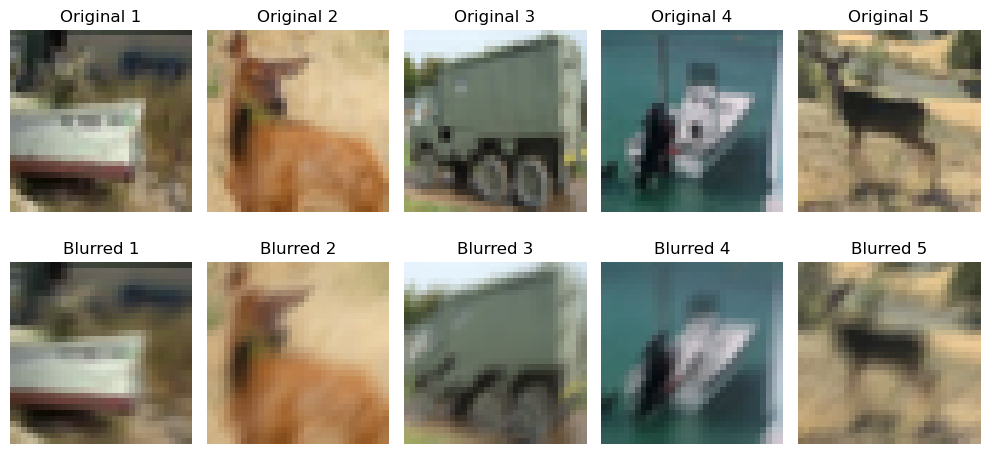

In [8]:
# Visualize some of the blurred data along with the original data
def visualize_blurring(x_orig, x_blurred, num_examples=5):

    num_examples = min(num_examples, len(x_blurred))
    indices = np.random.choice(len(x_blurred), num_examples, replace=False)
    sample_orig = x_orig[indices]
    sample_blurred = x_blurred[indices]

    plt.figure(figsize=(num_examples * 2, 5))
    for i in range(num_examples):

        ax = plt.subplot(2, num_examples, i + 1)
        plt.imshow(sample_orig[i])
        plt.title(f"Original {i+1}")
        plt.axis("off")

        ax = plt.subplot(2, num_examples, i + 1 + num_examples)
        plt.imshow(sample_blurred[i])
        plt.title(f"Blurred {i+1}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()


# Visualize some of the blurred data
visualize_blurring(x_train, x_train_blurred_mild, num_examples=5)

## Model architecture


We try to utilize the idea from U-Net for a similar implementation.


In [ ]:
# UNet architecture from UNet Segmentation notebook (simplified for cifar-10)
inputs = tf.keras.layers.Input(shape=(None, None, 3))

# Encoder
conv1 = tf.keras.layers.Conv2D(32, 3, activation="relu", padding="same")(inputs)
conv1 = tf.keras.layers.Conv2D(32, 3, activation="relu", padding="same")(conv1)
pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1)

conv2 = tf.keras.layers.Conv2D(64, 3, activation="relu", padding="same")(pool1)
conv2 = tf.keras.layers.Conv2D(64, 3, activation="relu", padding="same")(conv2)
pool2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)

# Bottleneck
conv3 = tf.keras.layers.Conv2D(128, 3, activation="relu", padding="same")(pool2)
conv3 = tf.keras.layers.Conv2D(128, 3, activation="relu", padding="same")(conv3)
drop3 = tf.keras.layers.Dropout(0.5)(conv3)

# Decoder
up4 = tf.keras.layers.Conv2DTranspose(64, 2, strides=(2, 2), padding="same")(drop3)
merge4 = tf.keras.layers.concatenate([conv2, up4], axis=3)
conv4 = tf.keras.layers.Conv2D(64, 3, activation="relu", padding="same")(merge4)
conv4 = tf.keras.layers.Conv2D(64, 3, activation="relu", padding="same")(conv4)

up5 = tf.keras.layers.Conv2DTranspose(32, 2, strides=(2, 2), padding="same")(conv4)
merge5 = tf.keras.layers.concatenate([conv1, up5], axis=3)
conv5 = tf.keras.layers.Conv2D(32, 3, activation="relu", padding="same")(merge5)
conv5 = tf.keras.layers.Conv2D(32, 3, activation="relu", padding="same")(conv5)

outputs = tf.keras.layers.Conv2D(3, 3, activation="sigmoid", padding="same")(conv5)

model = tf.keras.Model(inputs, outputs)

model.compile(optimizer="adam", loss="mse", metrics=["mae"])

# Print the model summary
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_69 (Conv2D)  │ (None, None,      │        896 │ input_layer_3[0]… │
│                     │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_70 (Conv2D)  │ (None, None,      │      9,248 │ conv2d_69[0][0]   │
│                     │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, None,      │          0 │ conv2d_70[0][0]   │
│ (MaxPooling2D)      │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_71 (Conv2D)  │ (None, None,      │     18,496 │ max_pooling2d[0]… │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_72 (Conv2D)  │ (None, None,      │     36,928 │ conv2d_71[0][0]   │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, None,      │          0 │ conv2d_72[0][0]   │
│ (MaxPooling2D)      │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_73 (Conv2D)  │ (None, None,      │     73,856 │ max_pooling2d_1[… │
│                     │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_74 (Conv2D)  │ (None, None,      │    147,584 │ conv2d_73[0][0]   │
│                     │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, None,      │          0 │ conv2d_74[0][0]   │
│                     │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_12 │ (None, None,      │     32,832 │ dropout_6[0][0]   │
│ (Conv2DTranspose)   │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_12      │ (None, None,      │          0 │ conv2d_72[0][0],  │
│ (Concatenate)       │ None, 128)        │            │ conv2d_transpose… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_75 (Conv2D)  │ (None, None,      │     73,792 │ concatenate_12[0… │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_76 (Conv2D)  │ (None, None,      │     36,928 │ conv2d_75[0][0]   │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_13 │ (None, None,      │      8,224 │ conv2d_76[0][0]   │
│ (Conv2DTranspose)   │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_13      │ (None, None,      │          0 │ conv2d_70[0][0],  │
│ (Concatenate)       │ None, 64)         │            │ conv2d_transpose… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_77 (Conv2D)  │ (None, None,      │     18,464 │ concatenate_13[0

 Total params: 467,363 (1.78 MB)

 Trainable params: 467,363 (1.78 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
EPOCHS = 1

start_time = time.time()

history = model.fit(
    x_train_blurred_medium, x_train, epochs=EPOCHS, batch_size=64, validation_split=0.2
)

end_time = time.time()
print(f"Training time: {end_time - start_time:.2f} seconds")

625/625 ━━━━━━━━━━━━━━━━━━━━ 120s 191ms/step - loss: 0.0070 - val_loss: 0.0054
Training time: 121.74 seconds


In [19]:
x_test_blurred_medium[1].shape

(32, 32, 3)

In [35]:
len(x_test_blurred_medium)

10000

In [36]:
def reconstruct_test_images(test_blurred_dataset, test_original_dataset=x_test):
    indices = np.random.choice(10000, 3, replace=False)

    for i in indices:
        blurred_image = test_blurred_dataset[i]  # get image
        blurred_image_batch = np.expand_dims(blurred_image, axis=0)  # batch size = 1
        deblurred_image = model.predict(blurred_image_batch)[0]  # predict image

        plt.figure(figsize=(15, 5))
        plt.subplot(131)
        plt.title("Original Image")
        plt.imshow(test_original_dataset[i])
        plt.axis("off")

        plt.subplot(132)
        plt.title("Blurred Image")
        plt.imshow(blurred_image)
        plt.axis("off")

        plt.subplot(133)
        plt.title("Deblurred Image")
        plt.imshow(deblurred_image)
        plt.axis("off")

        plt.show()

### Reconstruction of mildly blurred images


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


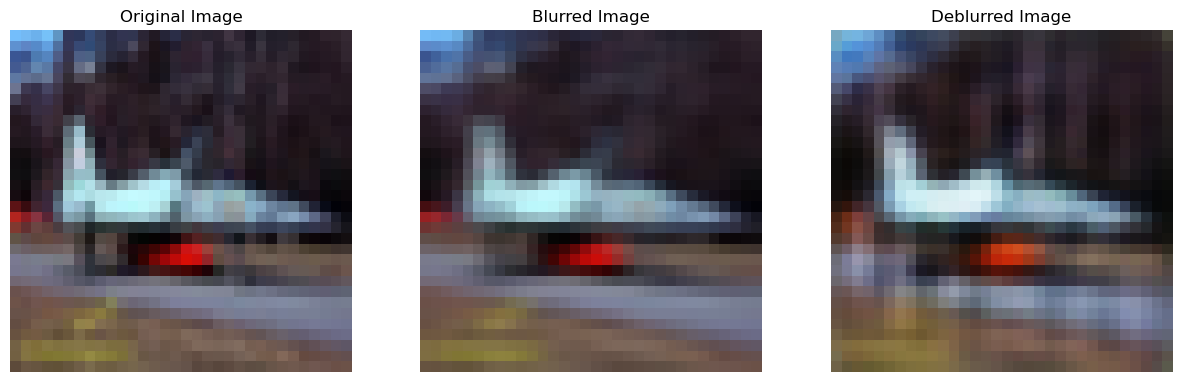

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


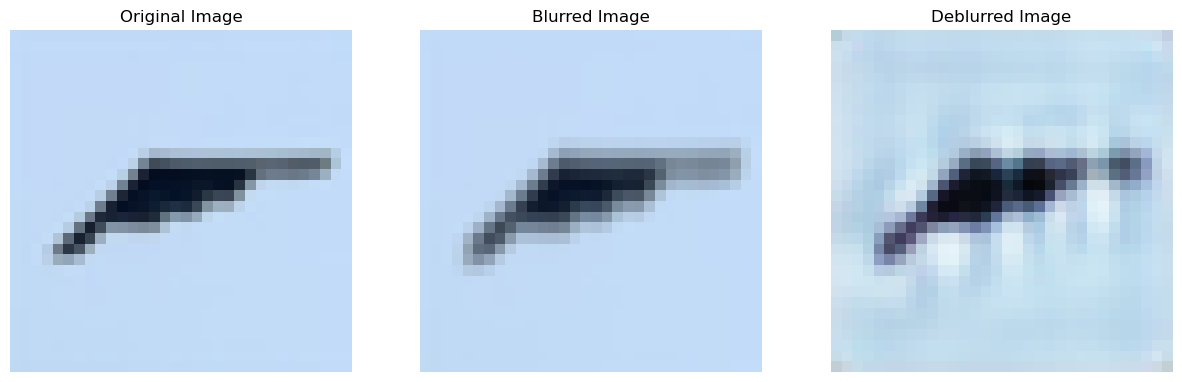

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


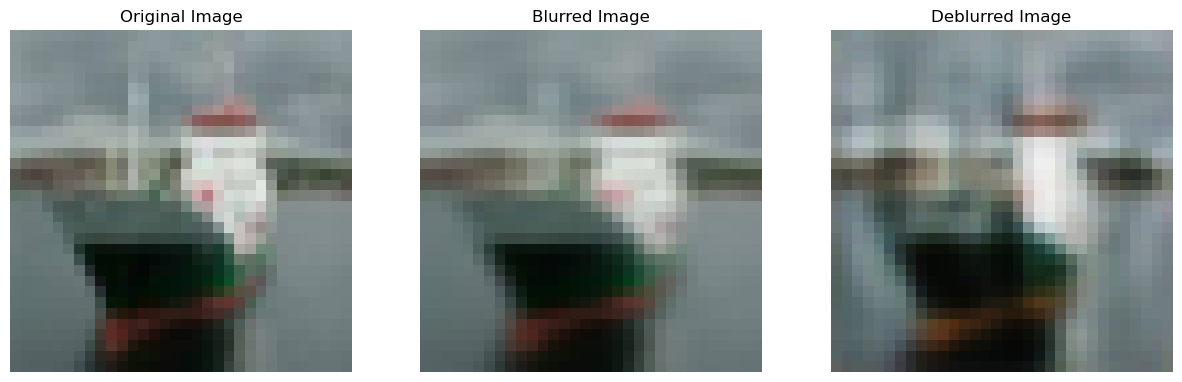

In [38]:
np.random.seed(12)  # set seed
reconstruct_test_images(x_test_blurred_mild)

### Reconstruction of strongly blurred images


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


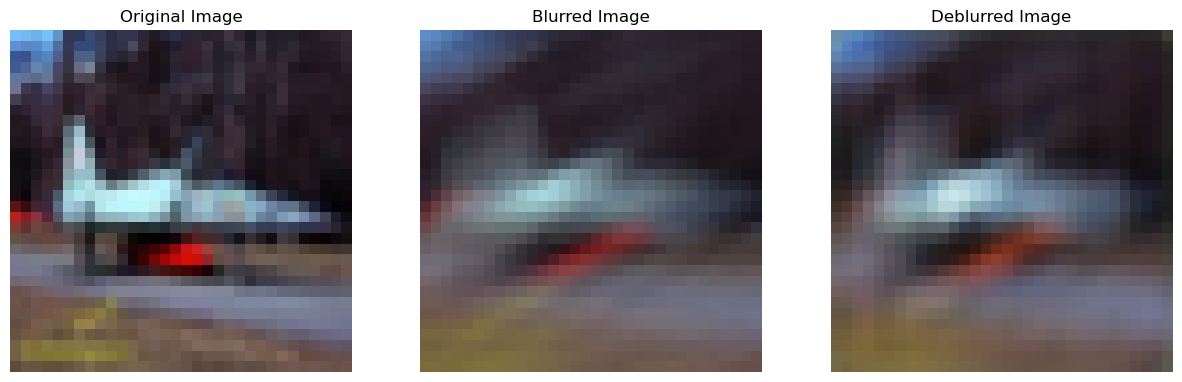

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


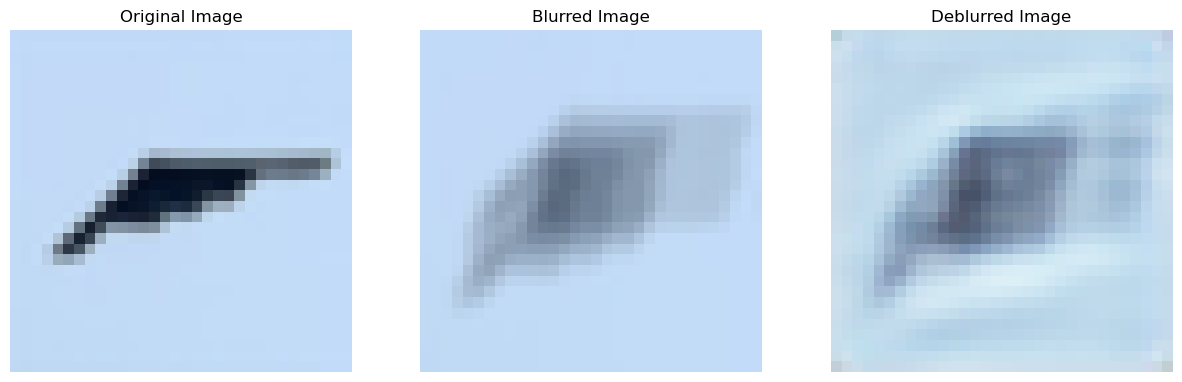

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


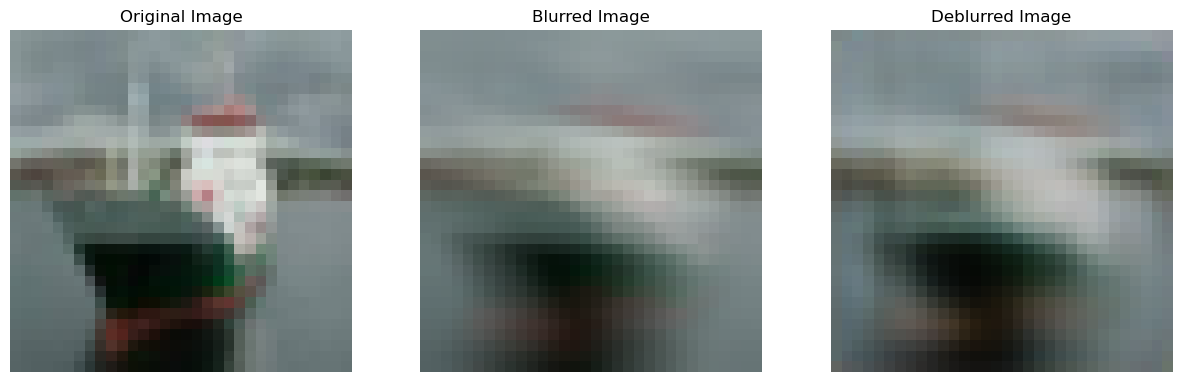

In [39]:
np.random.seed(12)  # set seed
reconstruct_test_images(x_test_blurred_strong)

## Plot metric over test images as a function of corruption strength


### SSIM & PSNR


In [ ]:
ssim_metric = lambda y_true, y_pred: tf.image.ssim(y_true, y_pred, max_val=1.0)
psnr_metric = lambda y_true, y_pred: tf.image.psnr(y_true, y_pred, max_val=1.0)

In [ ]:
blurred_test_datasets = [
    x_test_blurred_mild,
    x_test_blurred_medium,
    x_test_blurred_strong,
]
corruption_strength = ["mild", "medium", "strong"]


def evaluate_loss(
    original_images, blur_datasets, corruption_strength=corruption_strength
):
    loss_results = []
    batch_size = 16

    for blur_dataset in blur_datasets:
        blur_ds = tf.data.Dataset.from_tensor_slices(blur_dataset).batch(batch_size)
        orig_ds = tf.data.Dataset.from_tensor_slices(original_images).batch(batch_size)
        combined_ds = tf.data.Dataset.zip((blur_ds, orig_ds))

        losses = []
        for blurred_batch, original_batch in combined_ds:
            deblurred_batch = model(blurred_batch, training=False)
            loss = tf.reduce_mean(tf.square(original_batch - deblurred_batch))
            losses.append(float(loss))

        loss_results.append(np.mean(losses))

    # Plot loss
    plt.figure(figsize=(8, 5))
    plt.plot(corruption_strength, loss_results, "o-")
    plt.title("Loss vs Corruption Strength (lower is better)")
    plt.xlabel("Corruption Strength")
    plt.ylabel("MSE Loss (lower is better)")
    plt.show()

    return loss_results


def evaluate_ssim(
    original_images, blur_datasets, corruption_strength=corruption_strength
):
    ssim_results = []
    batch_size = 16

    for blur_dataset in blur_datasets:
        blur_ds = tf.data.Dataset.from_tensor_slices(blur_dataset).batch(batch_size)
        orig_ds = tf.data.Dataset.from_tensor_slices(original_images).batch(batch_size)
        combined_ds = tf.data.Dataset.zip((blur_ds, orig_ds))

        ssims = []
        for blurred_batch, original_batch in combined_ds:
            deblurred_batch = model(blurred_batch, training=False)
            ssim = tf.reduce_mean(
                tf.image.ssim(original_batch, deblurred_batch, max_val=1.0)
            )
            if not tf.math.is_nan(ssim):
                ssims.append(float(ssim))

        ssim_results.append(np.mean(ssims) if ssims else 0)

    plt.figure(figsize=(8, 5))
    plt.plot(corruption_strength, ssim_results, "o-")
    plt.title("SSIM vs Corruption Strength (higher is better)")
    plt.xlabel("Corruption Strength")
    plt.ylabel("SSIM (higher is better)")
    plt.show()

    return ssim_results


def evaluate_psnr(
    original_images, blur_datasets, corruption_strength=corruption_strength
):

    psnr_results = []
    batch_size = 16

    for blur_dataset in blur_datasets:
        blur_ds = tf.data.Dataset.from_tensor_slices(blur_dataset).batch(batch_size)
        orig_ds = tf.data.Dataset.from_tensor_slices(original_images).batch(batch_size)
        combined_ds = tf.data.Dataset.zip((blur_ds, orig_ds))

        psnrs = []
        for blurred_batch, original_batch in combined_ds:
            deblurred_batch = model(blurred_batch, training=False)
            psnr = tf.reduce_mean(
                tf.image.psnr(original_batch, deblurred_batch, max_val=1.0)
            )
            if not tf.math.is_nan(psnr):
                psnrs.append(float(psnr))

        psnr_results.append(np.mean(psnrs) if psnrs else 0)

    # Plot PSNR
    plt.figure(figsize=(8, 5))
    plt.plot(corruption_strength, psnr_results, "o-")
    plt.title("PSNR vs Corruption Strength (higher is better)")
    plt.xlabel("Corruption Strength")
    plt.ylabel("PSNR")
    plt.show()

    return psnr_results

In [ ]:
evaluate_loss(model, x_test, blurred_test_datasets, corruption_strength)

2025-04-17 13:12:09.796584: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-04-17 13:12:28.980120: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


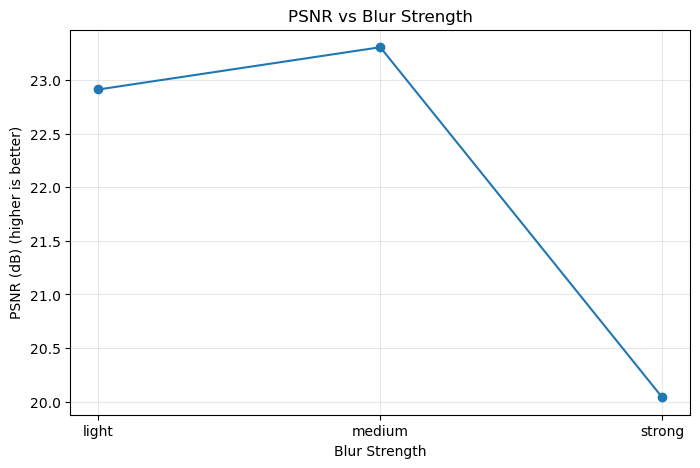

[22.911292642211915, 23.305228939819337, 20.041818154907226]

In [ ]:
evaluate_psnr(model, x_test, blurred_test_datasets, corruption_strength)

In [ ]:
evaluate_ssim(model, x_test, blurred_test_datasets, corruption_strength)